In [1]:
import numpy as np
import pandas as pd
import requests
import json
import re
from functools import reduce

In [2]:
import dateutil
from dateutil.parser import parse
import datetime
from sklearn import preprocessing
import seaborn as sns
from scipy import stats

getting weather *measurements* datapoints (for solar irradiance) from NREL SRRL BMS through the API:<br>
https://internal-apis.nrel.gov/intelligentcampus/hisRead?id=@p:stm_campus:r:20ed5df2-2c0e126b&range="2018-08-31%2c2018-09-02"

In the above request, note the manner in which the date range is specified.

to plug in the ID of the specific measurement (Dry Bulb Temperature in the following example) in the above link:<br>
NREL => Historian => Weather => NREL SRRL BMS => Dry Bulb Temperature => Aspects => Folio => ID

List of ids:
    - Energy Consumption => unit kwh => @p:nrel:r:225918db-bfbda16a
    - Relative Humidity (RH) => unit %RH  => @p:nrel:r:20ed5e0a-275dbdc2
    - Barometric Pressure (BP) => unit mbar  => @p:nrel:r:20ed5e0a-53e174aa
    - Dry Bulb Temperature (DBT) => unit degree Far => @p:nrel:r:20ed5e0a-fe755c80
    - Global Horizontal Irradiance (GHI) => unit watss/m2_irr => @p:nrel:r:20ed5df2-2c0e126b
    - Total Cloud Cover(TCC) => unit % => @p:nrel:r:20ed5e0a-acc8beff
    - Wind Speed at 19’ (5.7 meter) (WS) => unit mph => @p:nrel:r:20ed5df2-fd2eecc5
    

In [3]:
start_date = '2018-09-22'
end_date = '2018-11-22'
start_time = '00:01:00'
end_time = '23:59:00'

### requesting the data from API
- storing it in a dictionary

In [4]:
root_url = 'https://internal-apis.nrel.gov/intelligentcampus/hisRead?id='
reference_id = ['@p:stm_campus:r:225918db-bfbda16a','@p:stm_campus:r:20ed5e0a-275dbdc2',
                '@p:stm_campus:r:20ed5e0a-53e174aa','@p:stm_campus:r:20ed5e0a-fe755c80',
                '@p:stm_campus:r:20ed5df2-2c0e126b','@p:stm_campus:r:20ed5e0a-acc8beff',
                '@p:stm_campus:r:20ed5df2-fd2eecc5']
date_range = '&range=\"'+start_date+'%2c'+end_date+'\"'
feat_name = ['EC','RH','BP','DBT','GHI','TCC','WS']

response_dict = {}
for i in range(len(reference_id)):
    response_dict['resp_'+feat_name[i]] = requests.get(root_url+reference_id[i]+date_range)
    if response_dict['resp_'+feat_name[i]].status_code == 200:
        pass
    else:
        print("response from {} is not getting fetched from API".format(feat_name[i]))

In [5]:
EC = response_dict['resp_EC'].content.decode('utf-8').split("\n")
EC = EC[2:]
EC = filter(None, EC)
len(list(EC))

5952

In [6]:
def str_split(row):
    time_val = row.split(",")[0].strip(" Denver")
    energy_val = row.split(",")[1]
    energy_val = re.sub('[kwh%RHmbar°FW/m²_irrp]','', energy_val)
    return (time_val, float(energy_val))

def date_parser(row):
    parsed = parse(row)
    datetime_var = parsed.strftime(format='%m-%d-%y %H:%M:%S')
    date = parsed.date()
    time = parsed.time()
    return (datetime_var ,date, time)

### parsing the data (which came as string of non-json format) to get the timestamp and feat_value
- implemented to scale for all the input features
- str_split function used for splitting datetime and feat_values
- date_parser function used for converting the datetime into desired datetime strings

In [96]:
feat_name = ['EC','RH','BP','DBT','GHI','TCC','WS']
parsed_dict = {}
for i in range(len(feat_name)):
    parsed_dict[feat_name[i]] = response_dict['resp_'+feat_name[i]].content.decode('utf-8').split("\n")
    parsed_dict[feat_name[i]] = parsed_dict[feat_name[i]][2:]
    parsed_dict[feat_name[i]] = filter(None, parsed_dict[feat_name[i]])
    parsed_dict[feat_name[i]] = list(map(str_split, parsed_dict[feat_name[i]]))
    
    # the following line gives list (len 2) of lists (i.e. EC_dt and EC_value)
    # i.e. EC_dt, EC_value = EC[0], EC[1]
    parsed_dict[feat_name[i]] = list(zip(*parsed_dict[feat_name[i]]))
    
    # parsing the datetimeinfo obtained in above list into datetime string, date and time
    # the lists can be unpacked as:
    # EC_datetime, EC_date, EC_time = EC_dt_parsed[0], EC_dt_parsed[1], EC_dt_parsed[2]
    parsed_dict[feat_name[i]+'_dt_parsed'] = list(map(date_parser, parsed_dict[feat_name[i]][0]))
    parsed_dict[feat_name[i]+'_dt_parsed'] = list(zip(*parsed_dict[feat_name[i]+'_dt_parsed']))

In [97]:
parsed_dict.keys()

dict_keys(['RH_dt_parsed', 'DBT', 'EC', 'BP_dt_parsed', 'RH', 'WS_dt_parsed', 'TCC', 'GHI', 'TCC_dt_parsed', 'GHI_dt_parsed', 'DBT_dt_parsed', 'EC_dt_parsed', 'WS', 'BP'])

### sample feature (GHI) data pre-processing
- converting the parsed lists into dataframe
- inserting the intended first and the last time-stamp (if not present already)
- setting the index as DatetimeIndex to fill-in the missing time stamps
- filling in the nan values for the feature with the average of before and after value

In [166]:
df_GHI = pd.DataFrame({'datetime_str':parsed_dict['GHI_dt_parsed'][0],'GHI':parsed_dict['GHI'][1],},
                 columns=['datetime_str','GHI'])
print("shape of raw dataframe: {}".format(df_GHI.shape))
#df_GHI = df_GHI.set_index('datetime_str')

# Q1 = df_GHI.quantile(0.25)
# Q3 = df_GHI.quantile(0.75)
# IQR = Q3 - Q1
# print("IQR is: {}".format(IQR))
# print("Q1 is: {}".format(Q1))
# print("Q3 is: {}".format(Q3))
# lower_bound = (Q1 - 1.7 * IQR)
# upper_bound = (Q3 + 1.7 * IQR)
# df_GHI = df_GHI[~((df_GHI < lower_bound) |(df_GHI > upper_bound)).any(axis=1)]
# print("shape of outlier-removed dataframe: {}".format(df_GHI.shape))
# df_GHI = df_GHI.reset_index()
# print(df_GHI.head())

z_GHI = np.abs(stats.zscore(df_GHI['GHI']))
threshold = 3
mask = np.where(~(z_GHI > threshold))
print(len(mask))
df_GHI = df_GHI.iloc[mask]
print("shape of outlier-removed dataframe: {}".format(df_GHI.shape))

df_GHI['datetime_str'] = pd.to_datetime(df_GHI['datetime_str'])
if not (df_GHI.loc[0, 'datetime_str'] == pd.to_datetime(start_date+' '+start_time)):
    df_GHI.loc[0, 'datetime_str'] = pd.to_datetime(start_date+' '+start_time)
if not (df_GHI.loc[df_GHI.index[-1], 'datetime_str'] == pd.to_datetime(end_date+' '+end_time)):
    df_GHI.loc[df_GHI.index[-1], 'datetime_str'] = pd.to_datetime(end_date+' '+end_time)
    
df_GHI=df_GHI.set_index('datetime_str').resample("1min").first().reset_index().reindex(columns=df_GHI.columns)
cols = df_GHI.columns.difference(['GHI'])
df_GHI[cols] = df_GHI[cols].ffill()
# df_GHI['GHI'] = df_GHI['GHI'].fillna((df_GHI['GHI'].shift()+df_GHI['GHI'].shift(-1))/2)
df_GHI['GHI'] = df_GHI['GHI'].fillna(method='ffill')
print("shape of processed dataframe: {}".format(df_GHI.shape))

shape of raw dataframe: (88840, 2)
1
shape of outlier-removed dataframe: (88008, 2)
shape of processed dataframe: (89279, 2)


In [170]:
df_RH = pd.DataFrame({'datetime_str':parsed_dict['RH_dt_parsed'][0],'RH':parsed_dict['RH'][1],},
                 columns=['datetime_str','RH'])
print("shape of raw dataframe: {}".format(df_RH.shape))

z_RH = np.abs(stats.zscore(df_RH['RH']))
threshold = 2
mask = np.where(~(z_RH > threshold))
print(len(mask))
df_RH = df_RH.iloc[mask]
print("shape of outlier-removed dataframe: {}".format(df_RH.shape))

df_RH['datetime_str'] = pd.to_datetime(df_RH['datetime_str'])
if not (df_RH.loc[0, 'datetime_str'] == pd.to_datetime(start_date+' '+start_time)):
    df_RH.loc[0, 'datetime_str'] = pd.to_datetime(start_date+' '+start_time)
if not (df_RH.loc[df_RH.index[-1], 'datetime_str'] == pd.to_datetime(end_date+' '+end_time)):
    df_RH.loc[df_RH.index[-1], 'datetime_str'] = pd.to_datetime(end_date+' '+end_time)
    
df_RH=df_RH.set_index('datetime_str').resample("1min").first().reset_index().reindex(columns=df_RH.columns)
cols = df_RH.columns.difference(['RH'])
df_RH[cols] = df_RH[cols].ffill()
# df_GHI['GHI'] = df_GHI['GHI'].fillna((df_GHI['GHI'].shift()+df_GHI['GHI'].shift(-1))/2)
df_RH['RH'] = df_RH['RH'].fillna(method='ffill')
print("shape of processed dataframe: {}".format(df_RH.shape))

shape of raw dataframe: (88833, 2)
1
shape of outlier-removed dataframe: (88833, 2)
shape of processed dataframe: (89279, 2)


### scaling the above sample for all the input features (excluding the target feature :EC)
- using a dictionary to store the individual dataframes for the input features

In [172]:
input_feat_name = ['RH','BP','DBT','GHI','TCC','WS']
df_dict = {}
z_dict = {}
for i in range(len(input_feat_name)):
    df_dict["df_"+input_feat_name[i]] = pd.DataFrame({'datetime_str':parsed_dict[input_feat_name[i]+'_dt_parsed'][0],
                                                input_feat_name[i]:parsed_dict[input_feat_name[i]][1]},
                                               columns=['datetime_str',input_feat_name[i]])
    
    df_temp = df_dict["df_"+input_feat_name[i]]
    df_temp.name = "df_"+input_feat_name[i]
    print("raw_dataframe = {}, shape = {}".format(df_temp.name,df_temp.shape))
    
    z_temp = np.abs(stats.zscore(df_temp[input_feat_name[i]]))
    threshold = 3
    mask = np.where(~(z_temp > threshold))
    #print(len(mask))
    df_temp = df_temp.iloc[mask]
    print("shape of outlier-removed dataframe: {}".format(df_temp.shape))
    
    df_temp['datetime_str'] = pd.to_datetime(df_temp['datetime_str'])
    if not (df_temp.loc[0, 'datetime_str'] == pd.to_datetime(start_date+' '+start_time)):
        df_temp.loc[0, 'datetime_str'] = pd.to_datetime(start_date+' '+start_time)
    if not (df_temp.loc[df_temp.index[-1], 'datetime_str'] == pd.to_datetime(end_date+' '+end_time)):
        df_temp.loc[df_temp.index[-1], 'datetime_str'] = pd.to_datetime(end_date+' '+end_time)
    
    df_temp=df_temp.set_index('datetime_str').resample("1min").first().reset_index().reindex(columns=df_temp.columns)
    cols = df_temp.columns.difference([input_feat_name[i]])
    df_temp[cols] = df_temp[cols].ffill()
    df_temp[input_feat_name[i]] = df_temp[input_feat_name[i]].fillna(method='ffill')
    print("shape of processed dataframe: {} {}".format(df_temp.shape, '\n'))

    df_dict["df_"+input_feat_name[i]] = df_temp
    del df_temp

raw_dataframe = df_RH, shape = (88833, 2)
shape of outlier-removed dataframe: (88833, 2)
shape of processed dataframe: (89279, 2) 

raw_dataframe = df_BP, shape = (88833, 2)
shape of outlier-removed dataframe: (88825, 2)


/home/reopt/anaconda3/envs/python3_ve/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/reopt/anaconda3/envs/python3_ve/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


shape of processed dataframe: (89279, 2) 

raw_dataframe = df_DBT, shape = (88834, 2)
shape of outlier-removed dataframe: (88834, 2)
shape of processed dataframe: (89279, 2) 

raw_dataframe = df_GHI, shape = (88840, 2)
shape of outlier-removed dataframe: (88008, 2)
shape of processed dataframe: (89279, 2) 

raw_dataframe = df_TCC, shape = (88833, 2)
shape of outlier-removed dataframe: (88784, 2)
shape of processed dataframe: (89279, 2) 

raw_dataframe = df_WS, shape = (88845, 2)
shape of outlier-removed dataframe: (87569, 2)
shape of processed dataframe: (89279, 2) 



### Processing the EC raw values separately

In [173]:
df_EC = pd.DataFrame({'datetime_str':parsed_dict['EC_dt_parsed'][0],'EC':parsed_dict['EC'][1],},
                 columns=['datetime_str','EC'])

In [174]:
df_EC.tail()

,datetime_str,EC
5947,11-22-18 22:45:00,1030.372314
5948,11-22-18 23:00:00,1035.045410
5949,11-22-18 23:15:00,1041.634888
5950,11-22-18 23:30:00,1039.833496
5951,11-22-18 23:45:00,1035.173828


In [175]:
EC_start_time = '00:00:00'
EC_end_time = '23:45:00'

In [178]:
df_EC = pd.DataFrame({'datetime_str':parsed_dict['EC_dt_parsed'][0],'EC':parsed_dict['EC'][1],},
                 columns=['datetime_str','EC'])
print("shape of raw dataframe: {}".format(df_EC.shape))

z_EC = np.abs(stats.zscore(df_EC['EC']))
threshold = 3.2
mask = np.where(~(z_EC > threshold))
# print(len(mask))
df_EC = df_EC.iloc[mask]
print("shape of outlier-removed EC_dataframe: {}".format(df_EC.shape))

df_EC['datetime_str'] = pd.to_datetime(df_EC['datetime_str'])
if not (df_EC.loc[0, 'datetime_str'] == pd.to_datetime(start_date+' '+EC_start_time)):
    df_EC.loc[0, 'datetime_str'] = pd.to_datetime(start_date+' '+EC_start_time)
if not (df_EC.loc[df_EC.index[-1], 'datetime_str'] == pd.to_datetime(end_date+' '+EC_end_time)):
    df_EC.loc[df_EC.index[-1], 'datetime_str'] = pd.to_datetime(end_date+' '+EC_end_time)
    
df_EC=df_EC.set_index('datetime_str').resample("15min").first().reset_index().reindex(columns=df_EC.columns)
cols = df_EC.columns.difference(['EC'])
df_EC[cols] = df_EC[cols].ffill()
df_EC['EC'] = df_EC['EC'].fillna(method='ffill')
#df_EC['EC'] = df_EC['EC'].fillna(((df_EC['EC'].shift() + df_EC['EC'].shift(-1))/2))
print("shape of processed dataframe: {}".format(df_EC.shape))

shape of raw dataframe: (5952, 2)
shape of outlier-removed EC_dataframe: (5872, 2)
shape of processed dataframe: (5952, 2)


In [336]:
df_EC.head()

,datetime_str,EC
0,2018-10-22 00:00:00,1121.757446
1,2018-10-22 00:15:00,1124.623535
2,2018-10-22 00:30:00,1137.146484
3,2018-10-22 00:45:00,1127.491821
4,2018-10-22 01:00:00,1131.487305


### Merging and re-sampling the dataframes of the input features
- merge reference (https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes/44338256)

In [179]:
df_list = []
for key, value in df_dict.items():
    df_list.append(df_dict[key])
    
input_df = reduce(lambda left,right: pd.merge(left,right,on=['datetime_str'], how='outer'), df_list)

In [180]:
input_df.head()

,datetime_str,BP,DBT,TCC,RH,WS,GHI
0,2018-09-22 00:01:00,821.958496,59.341999,-1.0,44.630001,0.51451,-1.122176
1,2018-09-22 00:02:00,821.958496,59.341999,-1.0,44.630001,0.51451,-1.122176
2,2018-09-22 00:03:00,821.958496,59.341999,-1.0,44.630001,0.51451,-1.122176
3,2018-09-22 00:04:00,821.958496,59.341999,-1.0,44.630001,0.51451,-1.122176
4,2018-09-22 00:05:00,821.958496,59.341999,-1.0,44.630001,0.51451,-1.122176


In [181]:
input_df =input_df.set_index('datetime_str').resample("15min").mean().reset_index().reindex(columns=input_df.columns)

In [182]:
input_df.head()

,datetime_str,BP,DBT,TCC,RH,WS,GHI
0,2018-09-22 00:00:00,821.958235,59.294428,-1.0,44.653572,1.574849,-1.117198
1,2018-09-22 00:15:00,821.885038,59.999600,-1.0,41.964000,3.218747,-1.248616
2,2018-09-22 00:30:00,821.764042,59.987600,-1.0,41.037333,6.556353,-1.213172
3,2018-09-22 00:45:00,821.708521,59.730800,-1.0,41.453333,7.405071,-1.165230
4,2018-09-22 01:00:00,821.645154,59.679200,-1.0,39.594667,6.816590,-1.208046


### Merging input_df with df_EC

In [183]:
df = input_df.merge(df_EC, how='outer', on='datetime_str')

### feature engineering: adding new features 
- day of year
- time in sec
- cyclic time coordinates
- potentially adding:
    - friday_off, saturday_off, sunday_off
    - holidays

In [184]:
def get_static_features(df):
    # inserting new columns at index 7 and onward
    idx = 7
    new_col = df.datetime_str.dt.dayofyear.astype(np.float32)
    df.insert(loc=idx, column='Doy', value=new_col)

    idx = idx+1
    new_col = pd.to_timedelta(df.datetime_str.dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)
    df.insert(loc=idx, column='timeinSec', value=new_col)

    # conversion to cyclic coordinates
    seconds_in_day = 24 * 60 * 60

    idx = idx + 1
    new_col = np.sin(2 * np.pi * df.timeinSec / seconds_in_day)
    df.insert(loc=idx, column='sin_time', value=new_col)

    idx = idx+1
    new_col = np.cos(2 * np.pi * df.timeinSec / seconds_in_day)
    df.insert(loc=idx, column='cos_time', value=new_col)
    
    idx = idx+1
    new_col = df['EC'].shift(4)
    df.insert(loc=idx, column='EC_t-4', value=new_col)
    
    idx = idx+1
    new_col = df['EC'].shift(3)
    df.insert(loc=idx, column='EC_t-3', value=new_col)
    
    idx = idx+1
    new_col = df['EC'].shift(2)
    df.insert(loc=idx, column='EC_t-2', value=new_col)
    
    idx = idx+1
    new_col = df['EC'].shift(1)
    df.insert(loc=idx, column='EC_t-1', value=new_col)
    
    return df

### filling in the nan values created in rows 1 to 4
- getting the mean of the column for the rows where the time is same as the time of the Nan value cell

In [185]:
def fill_nan(df):
    df.loc[0,'EC_t-4'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[0].time()]['EC_t-4'].mean(axis=0)
    df.loc[1,'EC_t-4'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[1].time()]['EC_t-4'].mean(axis=0)
    df.loc[2,'EC_t-4'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[2].time()]['EC_t-4'].mean(axis=0)
    df.loc[3,'EC_t-4'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[3].time()]['EC_t-4'].mean(axis=0)

    df.loc[0,'EC_t-3'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[0].time()]['EC_t-3'].mean(axis=0)
    df.loc[1,'EC_t-3'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[1].time()]['EC_t-3'].mean(axis=0)
    df.loc[2,'EC_t-3'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[2].time()]['EC_t-3'].mean(axis=0)

    df.loc[0,'EC_t-2'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[0].time()]['EC_t-2'].mean(axis=0)
    df.loc[1,'EC_t-2'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[1].time()]['EC_t-2'].mean(axis=0)

    df.loc[0,'EC_t-1'] = df[df.datetime_str.apply(lambda x: x.time()) == df.datetime_str[0].time()]['EC_t-1'].mean(axis=0)
    
    return df

In [186]:
df.head()

,datetime_str,BP,DBT,TCC,RH,WS,GHI,EC
0,2018-09-22 00:00:00,821.958235,59.294428,-1.0,44.653572,1.574849,-1.117198,1038.780029
1,2018-09-22 00:15:00,821.885038,59.999600,-1.0,41.964000,3.218747,-1.248616,1040.429321
2,2018-09-22 00:30:00,821.764042,59.987600,-1.0,41.037333,6.556353,-1.213172,1035.406006
3,2018-09-22 00:45:00,821.708521,59.730800,-1.0,41.453333,7.405071,-1.165230,1028.428345
4,2018-09-22 01:00:00,821.645154,59.679200,-1.0,39.594667,6.816590,-1.208046,1027.310303


### EDA (before scaling)

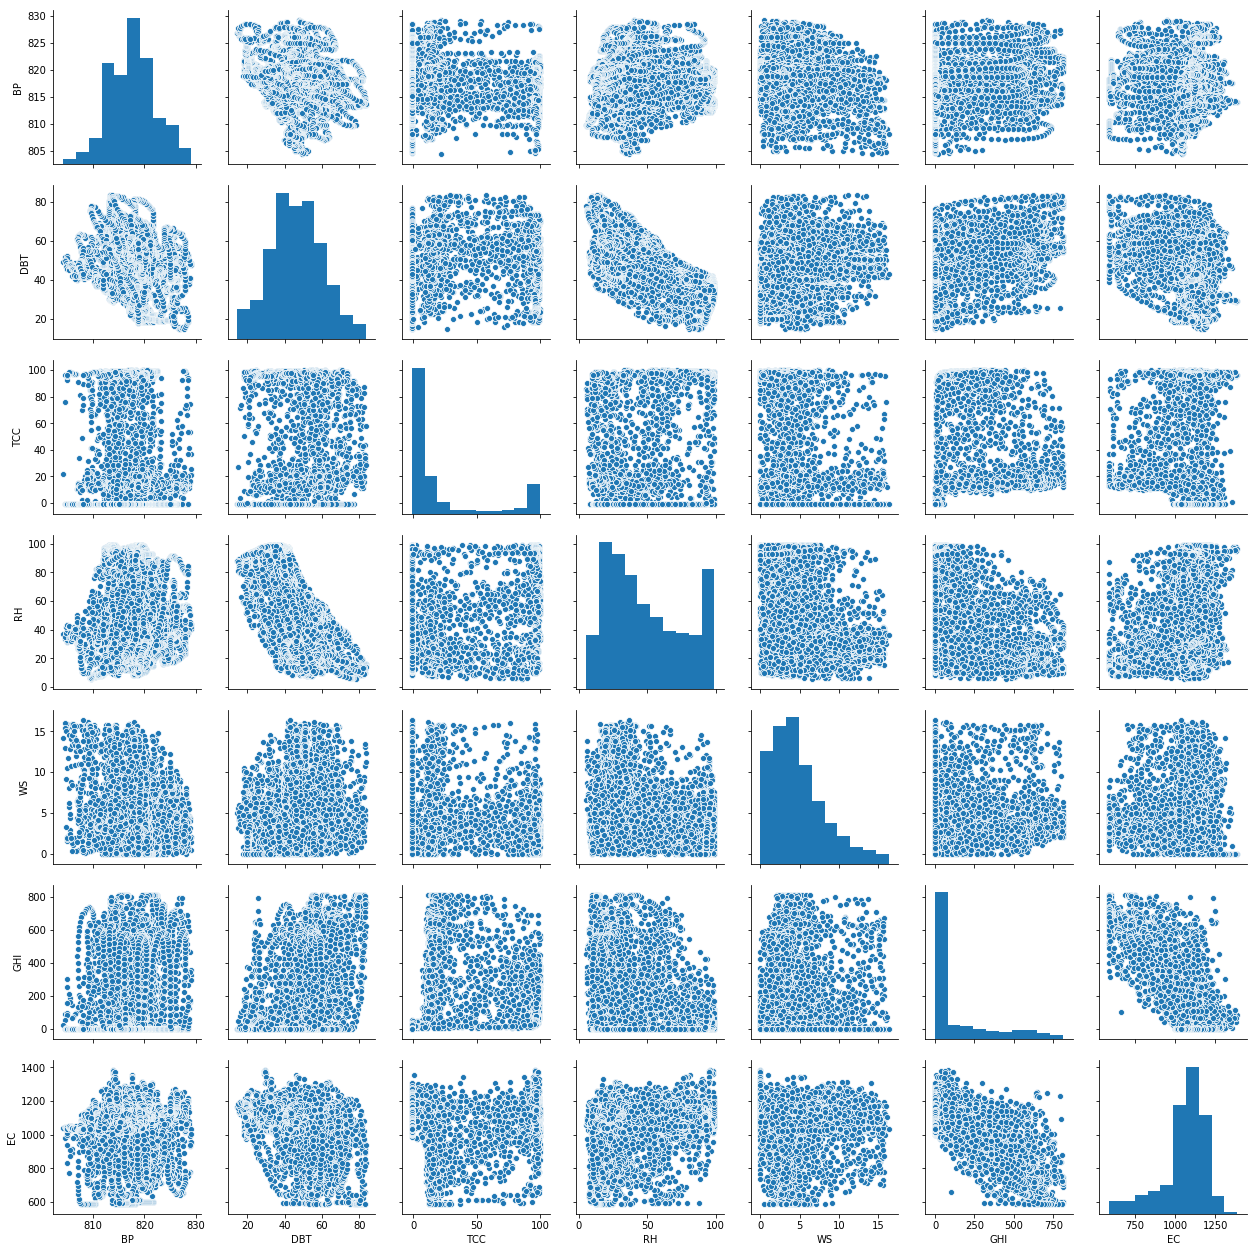

In [187]:
sns.pairplot(df)

In [188]:
df = get_static_features(df)
df = fill_nan(df)

In [189]:
df.head()

,datetime_str,BP,DBT,TCC,RH,WS,GHI,Doy,timeinSec,sin_time,cos_time,EC_t-4,EC_t-3,EC_t-2,EC_t-1,EC
0,2018-09-22 00:00:00,821.958235,59.294428,-1.0,44.653572,1.574849,-1.117198,265.0,0,0.000000,1.000000,1100.018797,1102.849793,1098.536811,1091.201048,1038.780029
1,2018-09-22 00:15:00,821.885038,59.999600,-1.0,41.964000,3.218747,-1.248616,265.0,900,0.065403,0.997859,1102.849793,1098.536811,1091.201048,1038.780029,1040.429321
2,2018-09-22 00:30:00,821.764042,59.987600,-1.0,41.037333,6.556353,-1.213172,265.0,1800,0.130526,0.991445,1098.536811,1091.201048,1038.780029,1040.429321,1035.406006
3,2018-09-22 00:45:00,821.708521,59.730800,-1.0,41.453333,7.405071,-1.165230,265.0,2700,0.195090,0.980785,1091.201048,1038.780029,1040.429321,1035.406006,1028.428345
4,2018-09-22 01:00:00,821.645154,59.679200,-1.0,39.594667,6.816590,-1.208046,265.0,3600,0.258819,0.965926,1038.780029,1040.429321,1035.406006,1028.428345,1027.310303


### Normalize, standardize or minmaxscaling 
- resouece to read up: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

In [190]:
final_df = df.copy()
final_df = final_df.drop('datetime_str', axis=1)
final_df.head()

,BP,DBT,TCC,RH,WS,GHI,Doy,timeinSec,sin_time,cos_time,EC_t-4,EC_t-3,EC_t-2,EC_t-1,EC
0,821.958235,59.294428,-1.0,44.653572,1.574849,-1.117198,265.0,0,0.000000,1.000000,1100.018797,1102.849793,1098.536811,1091.201048,1038.780029
1,821.885038,59.999600,-1.0,41.964000,3.218747,-1.248616,265.0,900,0.065403,0.997859,1102.849793,1098.536811,1091.201048,1038.780029,1040.429321
2,821.764042,59.987600,-1.0,41.037333,6.556353,-1.213172,265.0,1800,0.130526,0.991445,1098.536811,1091.201048,1038.780029,1040.429321,1035.406006
3,821.708521,59.730800,-1.0,41.453333,7.405071,-1.165230,265.0,2700,0.195090,0.980785,1091.201048,1038.780029,1040.429321,1035.406006,1028.428345
4,821.645154,59.679200,-1.0,39.594667,6.816590,-1.208046,265.0,3600,0.258819,0.965926,1038.780029,1040.429321,1035.406006,1028.428345,1027.310303


In [191]:
min_max_scaler = preprocessing.MinMaxScaler()
temp_cols1 = final_df.columns.values
minmax_df = pd.DataFrame(min_max_scaler.fit_transform(final_df.values), columns=temp_cols1)
minmax_df.head()

,BP,DBT,TCC,RH,WS,GHI,Doy,timeinSec,sin_time,cos_time,EC_t-4,EC_t-3,EC_t-2,EC_t-1,EC
0,0.712071,0.648715,0.0,0.418226,0.096115,0.000991,0.0,0.000000,0.500000,1.000000,0.640961,0.644522,0.639097,0.629868,0.563924
1,0.709124,0.658994,0.0,0.389487,0.196445,0.000829,0.0,0.010526,0.532702,0.998929,0.644522,0.639097,0.629868,0.563924,0.565999
2,0.704252,0.658819,0.0,0.379585,0.400144,0.000873,0.0,0.021053,0.565263,0.995722,0.639097,0.629868,0.563924,0.565999,0.559680
3,0.702017,0.655076,0.0,0.384030,0.451942,0.000932,0.0,0.031579,0.597545,0.990393,0.629868,0.563924,0.565999,0.559680,0.550902
4,0.699466,0.654324,0.0,0.364170,0.416027,0.000879,0.0,0.042105,0.629410,0.982963,0.563924,0.565999,0.559680,0.550902,0.549496


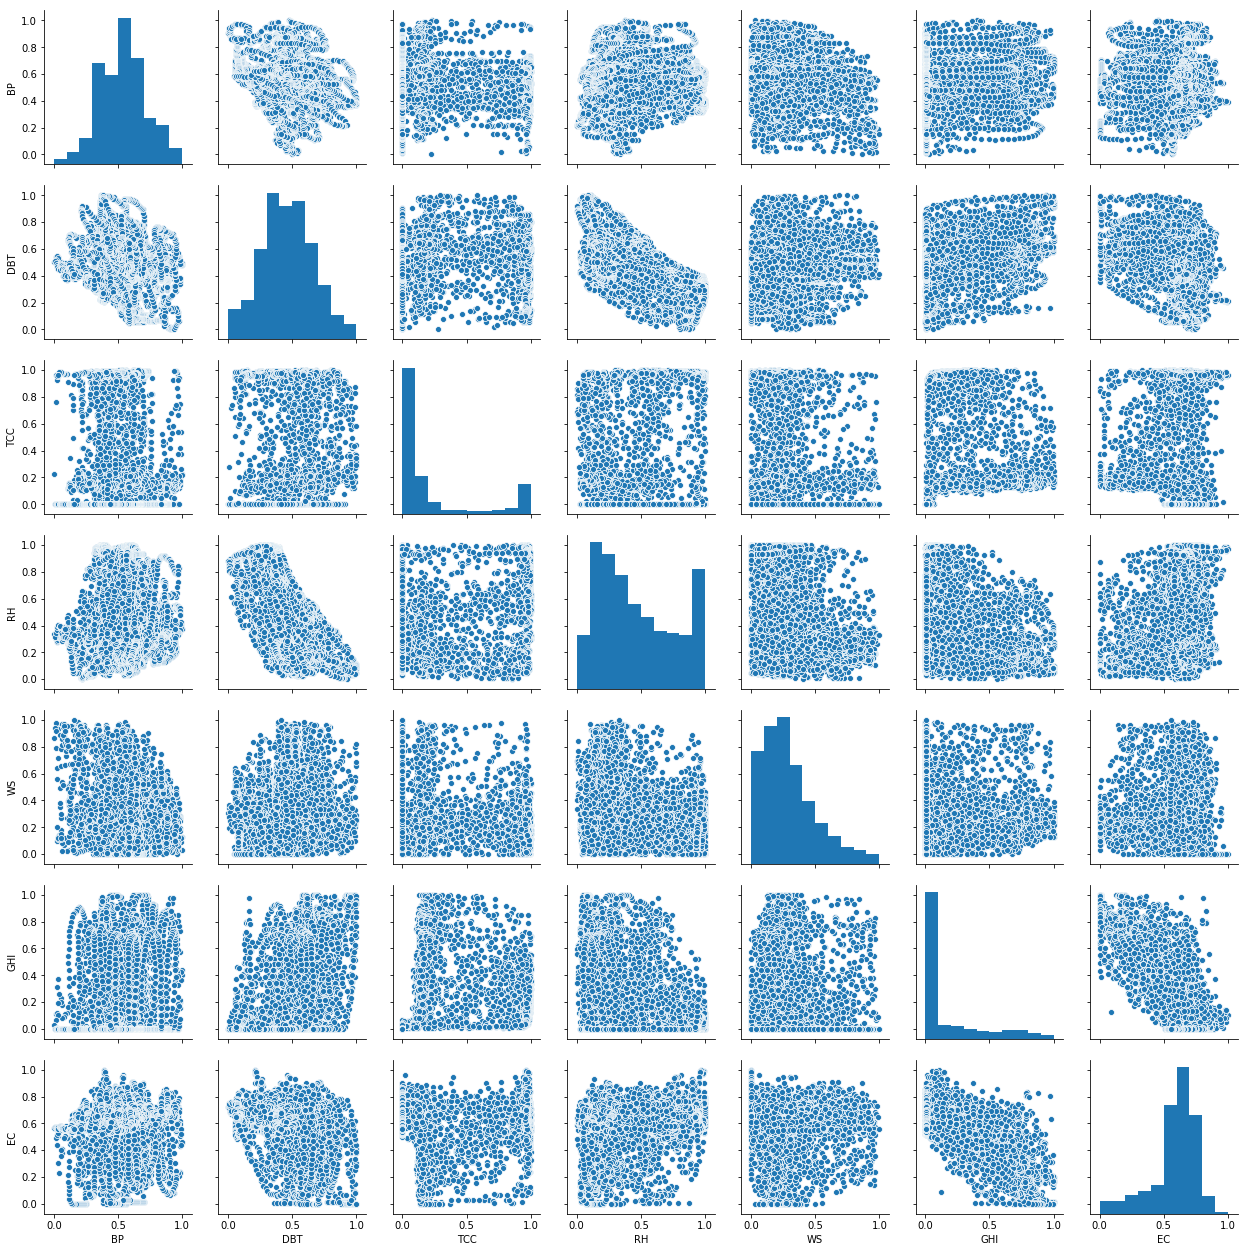

In [192]:
sns.pairplot(minmax_df[['BP','DBT','TCC','RH','WS','GHI','EC']])

In [193]:
stand_scaler = preprocessing.StandardScaler()
temp_cols2 = final_df.columns.values
stand_df = pd.DataFrame(stand_scaler.fit_transform(final_df.values), columns=temp_cols2)
stand_df.head()

,BP,DBT,TCC,RH,WS,GHI,Doy,timeinSec,sin_time,cos_time,EC_t-4,EC_t-3,EC_t-2,EC_t-1,EC
0,0.943967,0.928373,-0.625153,-0.163962,-0.942592,-0.635749,-1.704336,-1.714102,0.000000,1.414214,0.323491,0.343537,0.313193,0.261525,-0.108142
1,0.927815,0.979890,-0.625153,-0.262421,-0.472737,-0.636347,-1.704336,-1.678015,0.092494,1.411186,0.343458,0.313118,0.261454,-0.108208,-0.096509
2,0.901117,0.979014,-0.625153,-0.296344,0.481208,-0.636186,-1.704336,-1.641929,0.184592,1.402115,0.313039,0.261379,-0.108276,-0.096575,-0.131939
3,0.888866,0.960253,-0.625153,-0.281115,0.723787,-0.635968,-1.704336,-1.605843,0.275899,1.387040,0.261300,-0.108348,-0.096644,-0.132005,-0.181154
4,0.874883,0.956483,-0.625153,-0.349156,0.555589,-0.636163,-1.704336,-1.569756,0.366025,1.366025,-0.108424,-0.096715,-0.132074,-0.181220,-0.189040


In [ ]:
sns.pairplot(stand_df[['BP','DBT','TCC','RH','WS','GHI','EC']])

In [ ]:
np.where(np.isnan(final_df.values))

In [ ]:
temp_cols3 = final_df.columns.values
norm_df = pd.DataFrame(preprocessing.normalize(final_df.values), columns=temp_cols3)
norm_df.head()

In [ ]:
sns.pairplot(norm_df[['BP','DBT','TCC','RH','WS','GHI','EC']])